In [1]:
import torch
import numpy as np 
import pandas as pd
import os
import timm
import torch.nn as nn
import torch.optim as optim
from torch.nn.functional import softmax
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from torchvision import datasets, transforms
from tqdm import tqdm
from torch.utils.data import DataLoader,random_split
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

In [2]:
dataset_path = "/kaggle/input/dataset/dataset" 
print("Dataset contents:", os.listdir(dataset_path))

Dataset contents: ['val', 'train']


In [3]:
def load_data(directory):
    data, labels = [], []
    class_names = sorted(os.listdir(directory))  
    for label, class_name in enumerate(class_names):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path): 
            for filename in os.listdir(class_path):
                if filename.endswith(".npy"):
                    file_path = os.path.join(class_path, filename)
                    array = np.load(file_path)
                    data.append(array)
                    labels.append(label)  
    return np.array(data), np.array(labels)

In [4]:
train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "val")

In [5]:
X_train, y_train = load_data(train_dir)
X_val, y_val = load_data(val_dir)

In [6]:
device="cpu"
if torch.cuda.is_available():
    device="cuda"

# **Applying Log Transformation to an Image**

## **Formula for Log Transformation**  
The transformation follows the formula:

$$ S = c \times \log(1 + R) $$

Where:  
- \( S \) is the transformed pixel value.  
- \( R \) is the original pixel value.  
- \( c \) is a scaling constant, typically computed as:

  $$ c = \frac{255}{\log(1 + \max(R))} $$

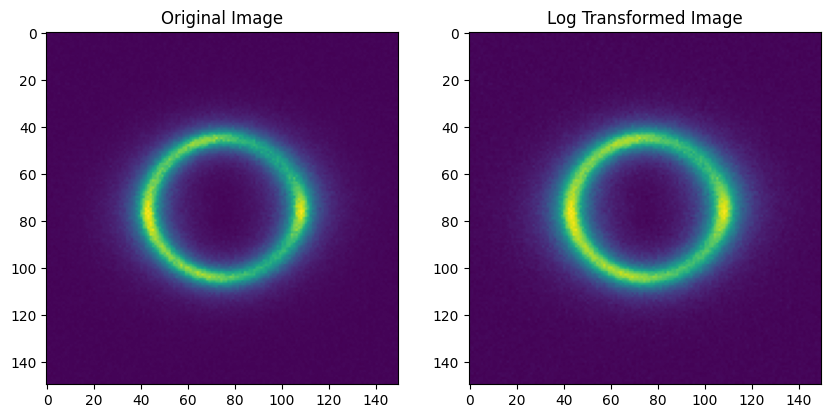

In [7]:
import matplotlib.pyplot as plt
image=X_train[0].squeeze()
c = 255 / np.log(1 + np.max(image))
log_transformed = c * np.log(1 + image.astype(np.float32))
log_transformed = np.uint8(log_transformed)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1), plt.imshow(image), plt.title("Original Image")
plt.subplot(1,2,2), plt.imshow(log_transformed), plt.title("Log Transformed Image")
plt.show()

In [8]:
from PIL import Image
class LogTransform:
    def __call__(self, image):
        if isinstance(image, torch.Tensor):
            image = image.numpy()
            if image.ndim == 3 and image.shape[0] == 1:
                image = image[0]
        else:
            image = np.array(image)
        image = image.astype(np.float32)
        c = 255 / np.log(1 + np.max(image) + 1e-6)
        log_transformed = c * np.log(1 + image)
        log_transformed = np.clip(log_transformed, 0, 255).astype(np.uint8)
        if log_transformed.ndim == 3 and log_transformed.shape[-1] == 1:
            log_transformed = log_transformed.squeeze(-1)
        return Image.fromarray(log_transformed)

In [9]:
class Dataset():
    def __init__(self, x, y,transform):
        self.x = x
        self.y = y
        self.transform = transform 
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        image = torch.tensor(self.x[idx], dtype=torch.float32)  
        label = torch.tensor(self.y[idx], dtype=torch.long)
        if self.transform:
            image = self.transform(image) 
        return {"x": image, "y": label}

In [10]:
transform = transforms.Compose([
    LogTransform(),  
    transforms.ToTensor(), 
])
train_dataset = Dataset(X_train, y_train,transform=transform)
train_ratio = 0.9
val_ratio = 1 - train_ratio
num_samples = len(train_dataset)
train_size = int(train_ratio * num_samples)
val_size = num_samples - train_size 
train_dataset0, test_dataset = random_split(train_dataset, [train_size, val_size])
val_dataset=Dataset(X_val,y_val,transform=transform)
train_loader = DataLoader(train_dataset0, batch_size=64, shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=64,shuffle=False)
val_loader=DataLoader(val_dataset,batch_size=64,shuffle=False)

In [11]:
def train(train_loader, test_loader, model, criterion, optimizer, epochs, device):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        model.train()
        
        for i in tqdm(train_loader):
            x = i["x"].to(device)
            y = i["y"].to(device)
            batch = x.shape[0]
            x = x.view(batch, 1, 150, 150)

            out = model(x)
            optimizer.zero_grad()
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

        print("Evaluating on test set...")
        model.eval()
        pred_list = []
        true_list = []
        prob_list = []
        with torch.no_grad():
            for i in test_loader:
                x = i["x"].to(device)
                y = i["y"].to(device)
                batch = x.shape[0]
                x = x.view(batch, 1, 150, 150)

                out = model(x)
                prob = F.softmax(out, dim=1)  
                pred = torch.argmax(prob, dim=1)

                pred_list.extend(pred.cpu().numpy())
                true_list.extend(y.cpu().numpy())
                prob_list.extend(prob.cpu().numpy()) 
        acc = accuracy_score(true_list, pred_list)
        print(f"Test Accuracy: {acc:.4f}")
        num_classes = 3  
        true_one_hot = np.eye(num_classes)[true_list]
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        for class_idx in range(num_classes):
            fpr, tpr, _ = roc_curve(true_one_hot[:, class_idx], np.array(prob_list)[:, class_idx])
            roc_auc = auc(fpr, tpr)
            axes[0].plot(fpr, tpr, label=f'Class {class_idx} (AUC = {roc_auc:.4f})')
        axes[0].plot([0, 1], [0, 1], linestyle="--", color="gray") 
        axes[0].set_xlabel("False Positive Rate")
        axes[0].set_ylabel("True Positive Rate")
        axes[0].set_title(f"ROC Curve - Epoch {epoch+1}")
        axes[0].legend()
        cm = confusion_matrix(true_list, pred_list)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax=axes[1], cmap=plt.cm.Blues, values_format="d")
        axes[1].set_title(f"Confusion Matrix - Epoch {epoch+1}")
        plt.tight_layout()
        plt.show()

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
def pred(t_loader, model, num_classes=3):
    model.eval()
    prob_list = []
    true_list = []
    with torch.no_grad():
        for i in t_loader:
            x = i["x"].to(device)
            y = i["y"].cpu().numpy() 
            batch = x.shape[0]
            x = x.view(batch, 1, 150, 150)
            out = model(x)
            prob = F.softmax(out, dim=1).cpu().numpy()  
            prob_list.append(prob)
            true_list.append(y)
    probs = np.vstack(prob_list)
    true_labels = np.concatenate(true_list) 
    roc_auc = roc_auc_score(true_labels, probs, multi_class="ovr")
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve((true_labels == i).astype(int), probs[:, i])
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc_score((true_labels == i).astype(int), probs[:, i]):.4f})")
    plt.plot([0, 1], [0, 1], "k--") 
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()
    predicted_labels = np.argmax(probs, axis=1)
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues, values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

In [21]:
model=timm.create_model(model_name='resnet18',pretrained=True,num_classes=3).to(device)
optimizer=torch.optim.RAdam(model.parameters(),lr=0.001)
criterion=nn.CrossEntropyLoss().to(device)

In [22]:
model.conv1=nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

# Training Model on resnet18

Epoch 1/15


100%|██████████| 422/422 [00:23<00:00, 17.64it/s]


Evaluating on test set...
Test Accuracy: 0.3477


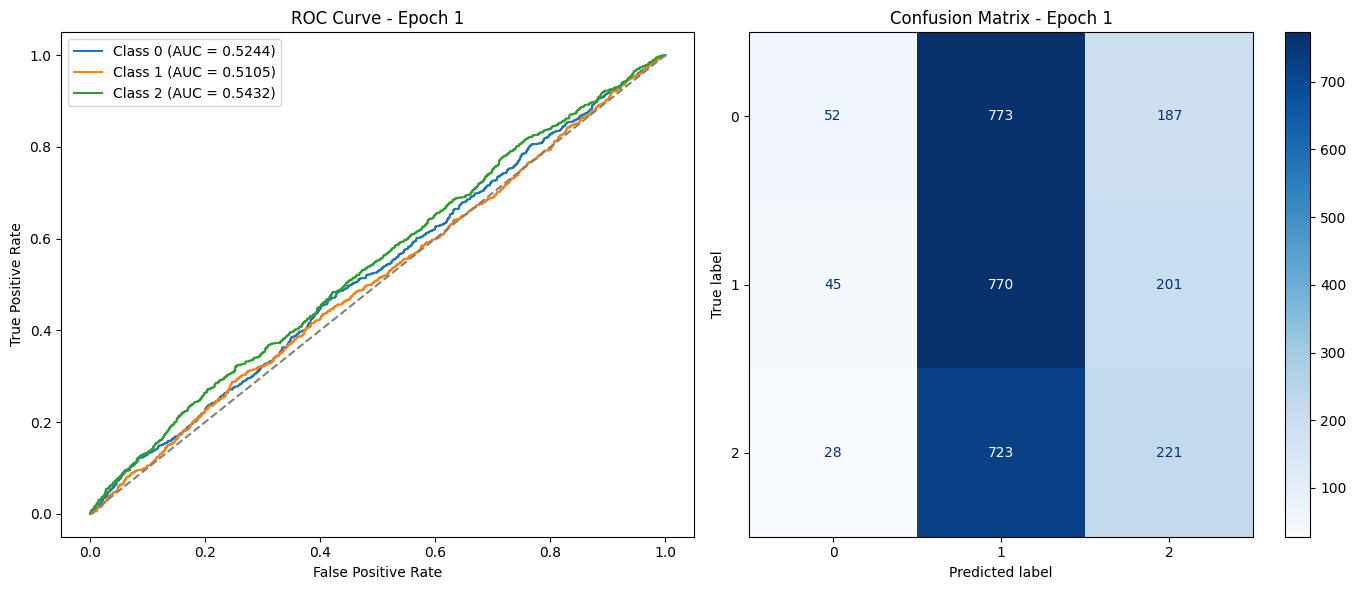

Epoch 2/15


100%|██████████| 422/422 [00:23<00:00, 17.65it/s]


Evaluating on test set...
Test Accuracy: 0.3743


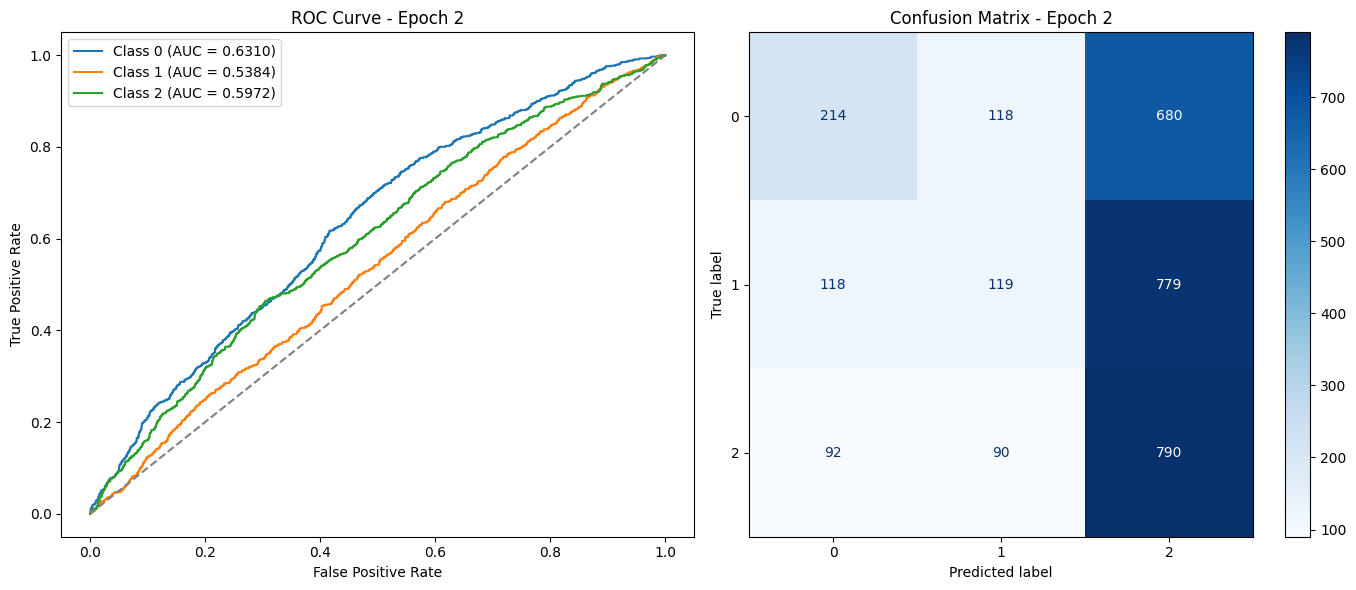

Epoch 3/15


100%|██████████| 422/422 [00:23<00:00, 17.64it/s]


Evaluating on test set...
Test Accuracy: 0.5127


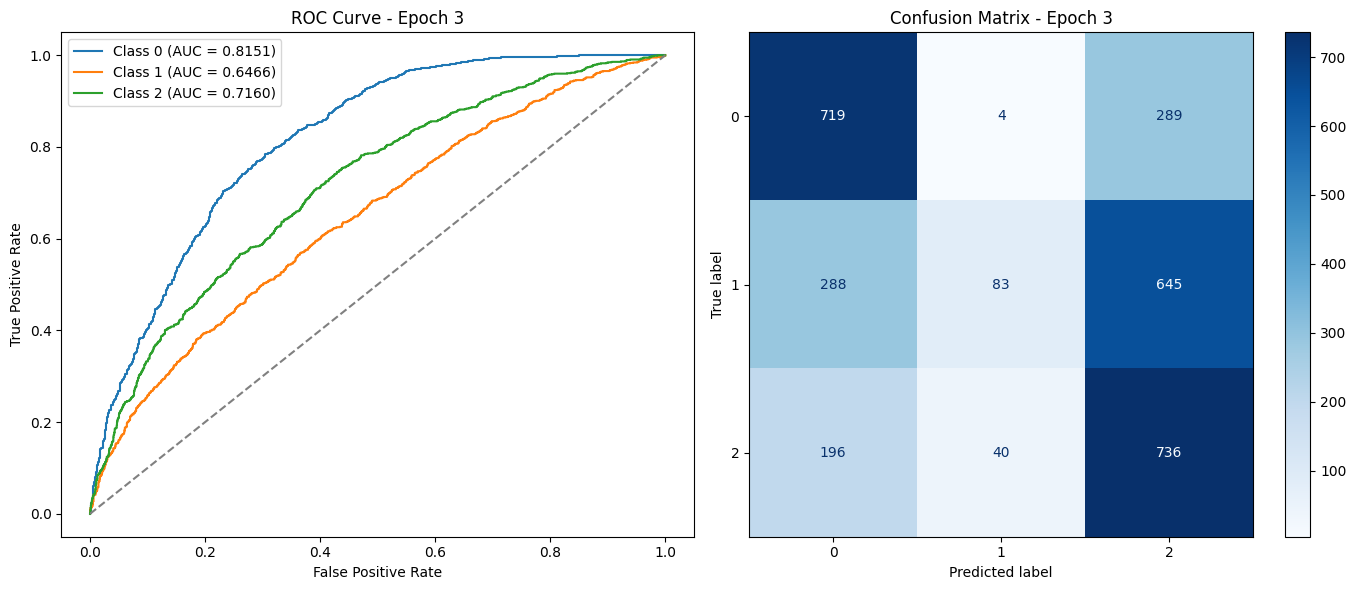

Epoch 4/15


100%|██████████| 422/422 [00:23<00:00, 17.64it/s]


Evaluating on test set...
Test Accuracy: 0.5760


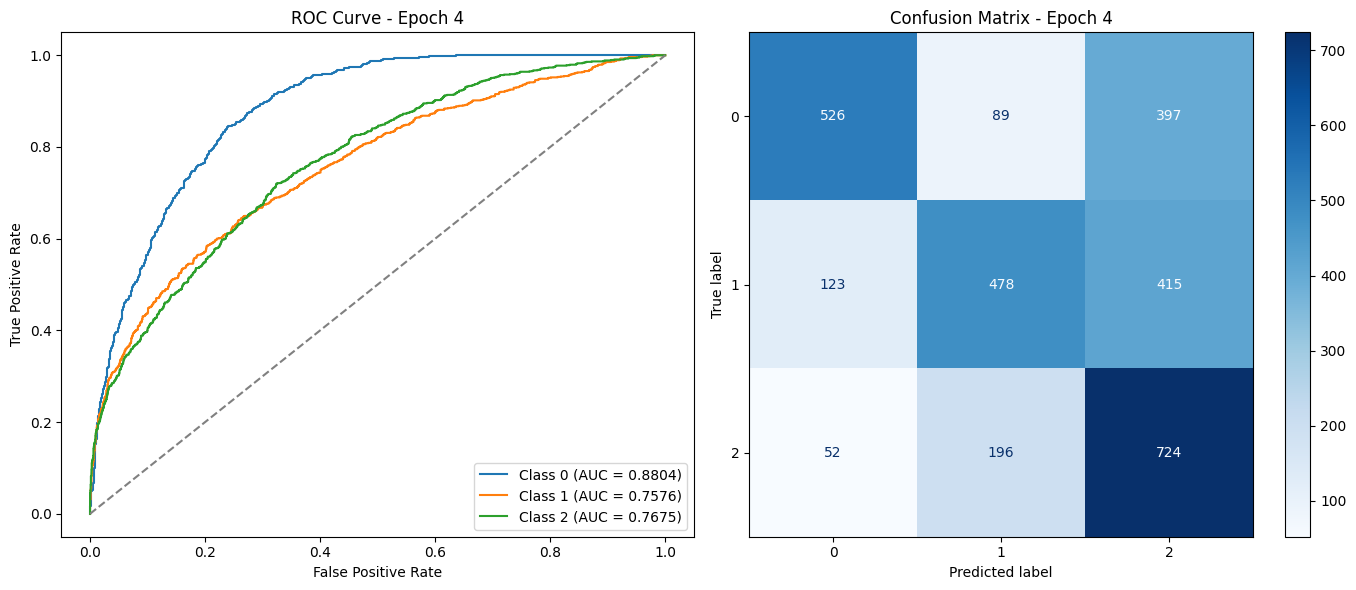

Epoch 5/15


100%|██████████| 422/422 [00:23<00:00, 17.64it/s]


Evaluating on test set...
Test Accuracy: 0.7367


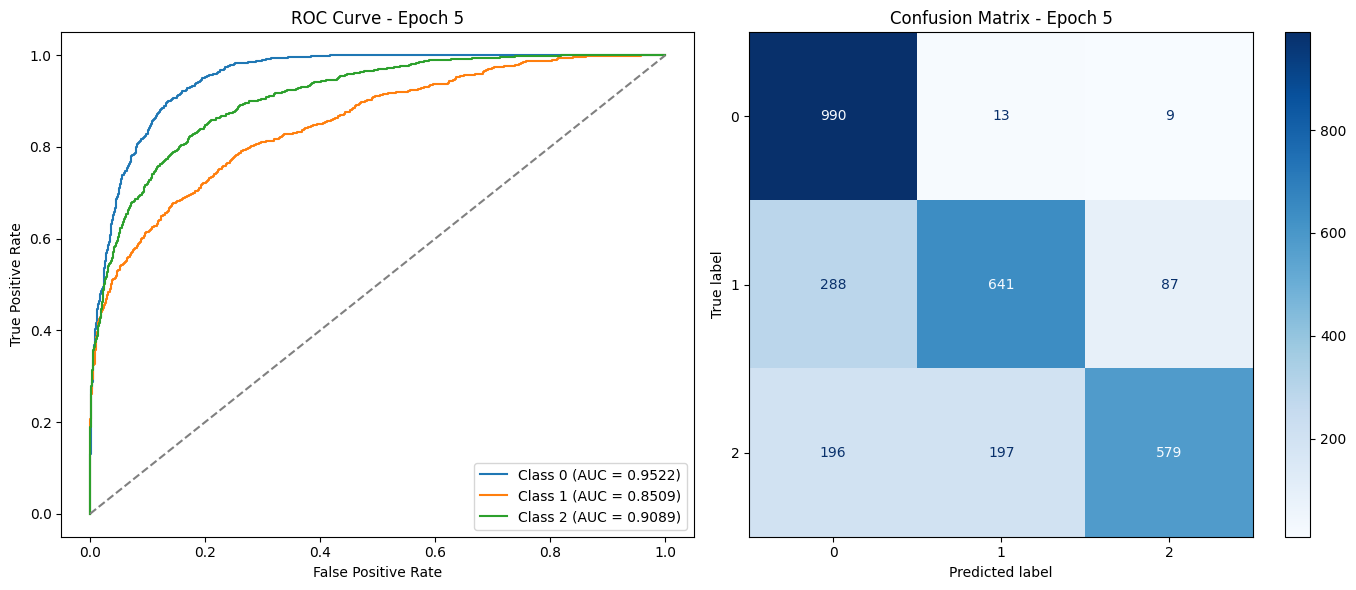

Epoch 6/15


100%|██████████| 422/422 [00:23<00:00, 17.63it/s]


Evaluating on test set...
Test Accuracy: 0.8013


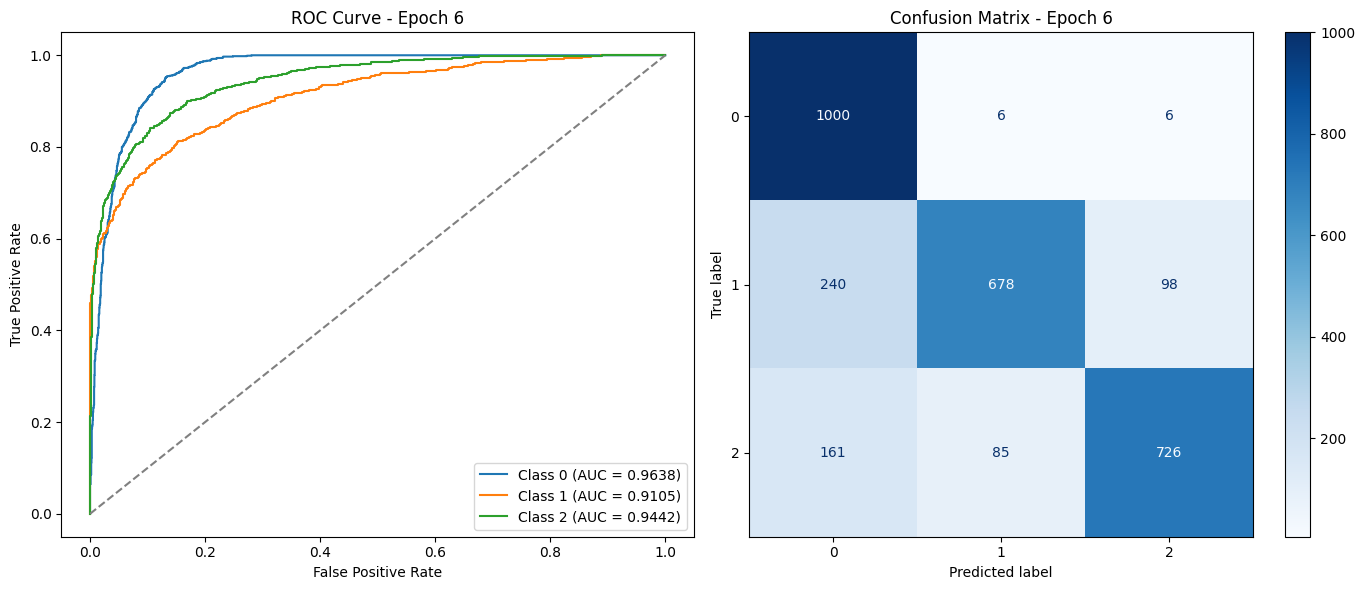

Epoch 7/15


100%|██████████| 422/422 [00:23<00:00, 17.64it/s]


Evaluating on test set...
Test Accuracy: 0.7393


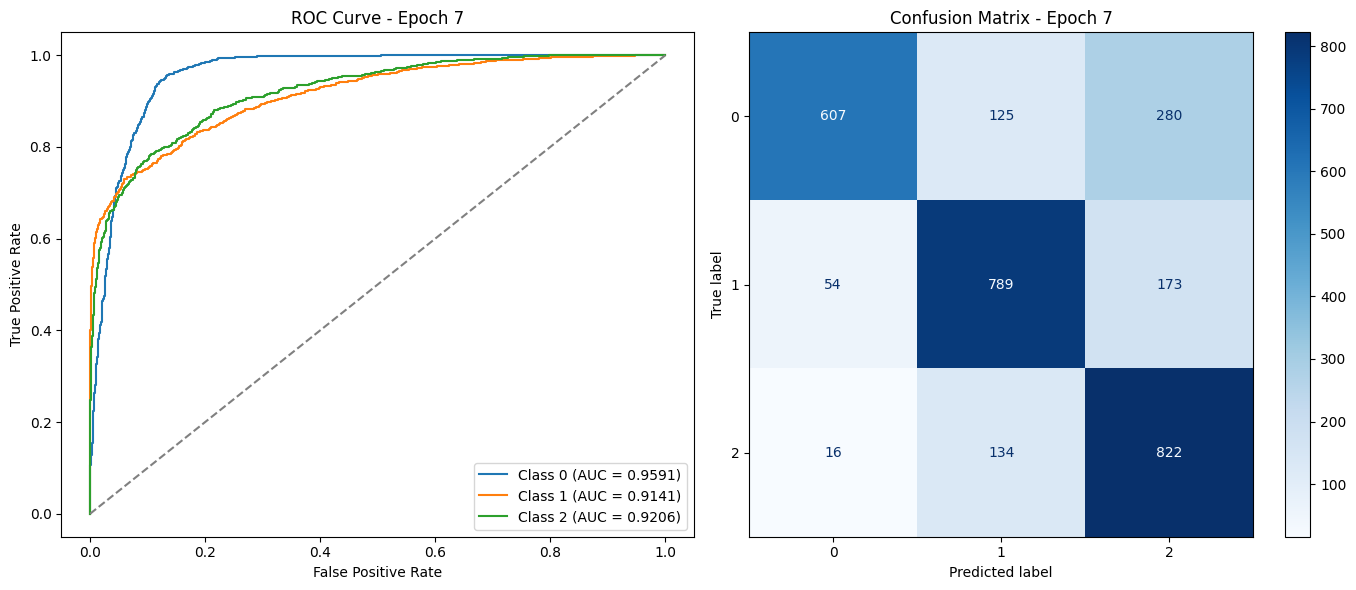

Epoch 8/15


100%|██████████| 422/422 [00:23<00:00, 17.64it/s]


Evaluating on test set...
Test Accuracy: 0.8417


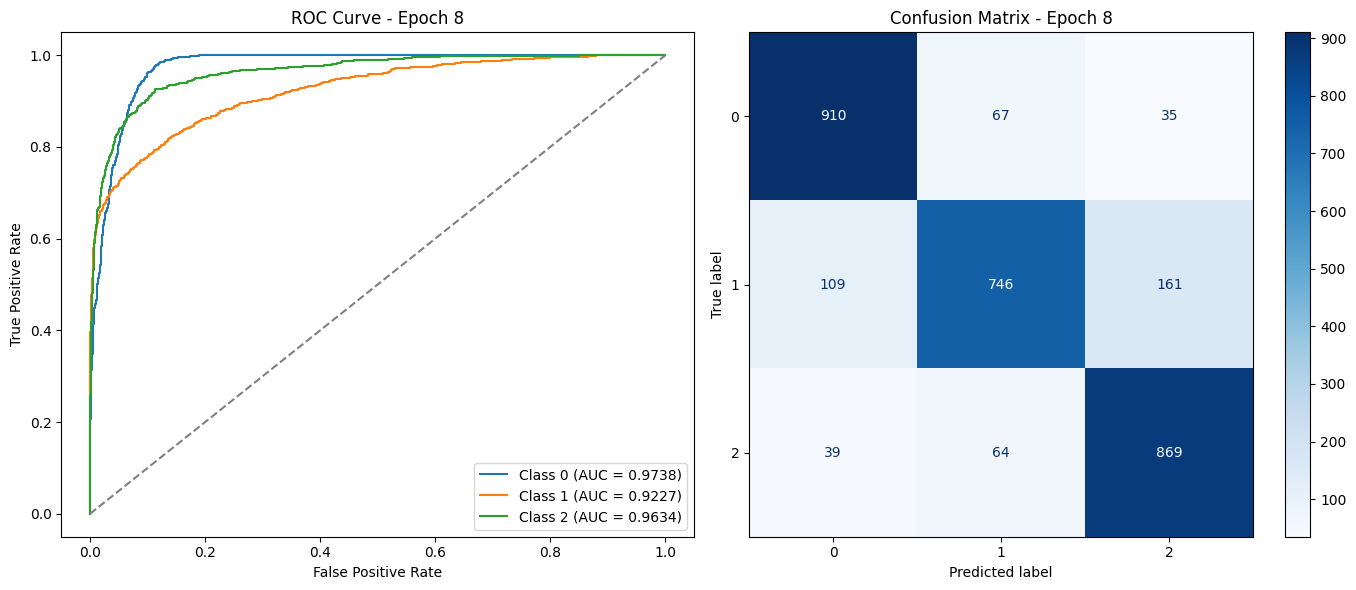

Epoch 9/15


100%|██████████| 422/422 [00:23<00:00, 17.65it/s]


Evaluating on test set...
Test Accuracy: 0.8660


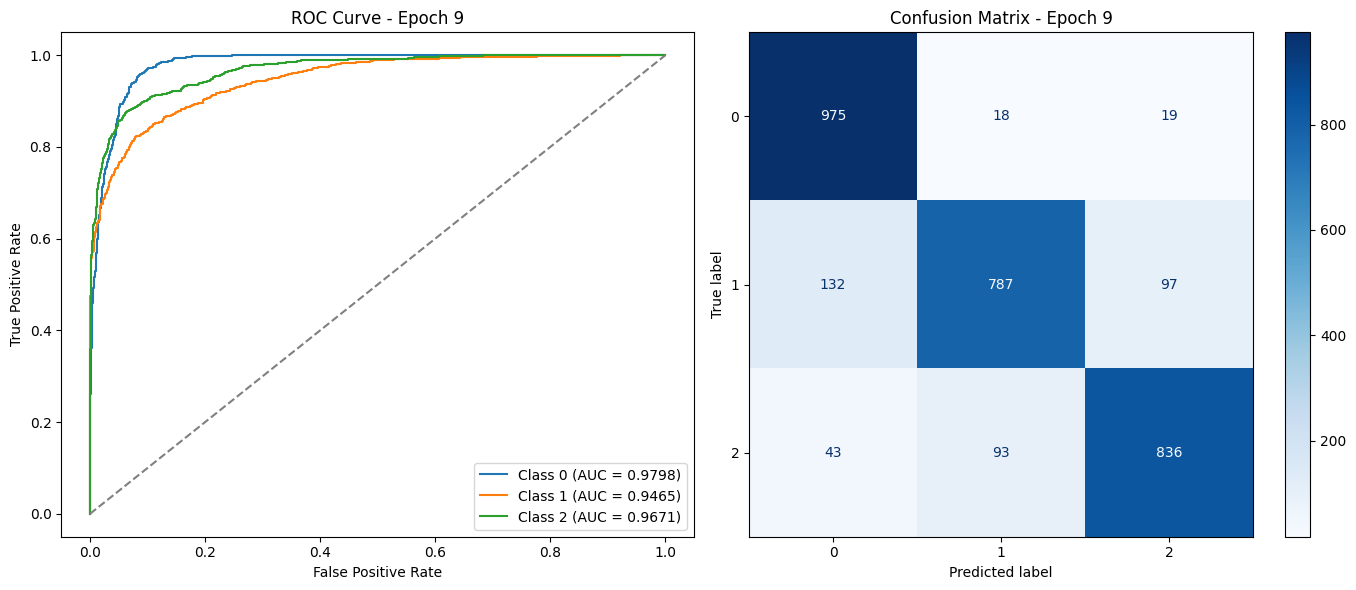

Epoch 10/15


100%|██████████| 422/422 [00:23<00:00, 17.66it/s]


Evaluating on test set...
Test Accuracy: 0.8513


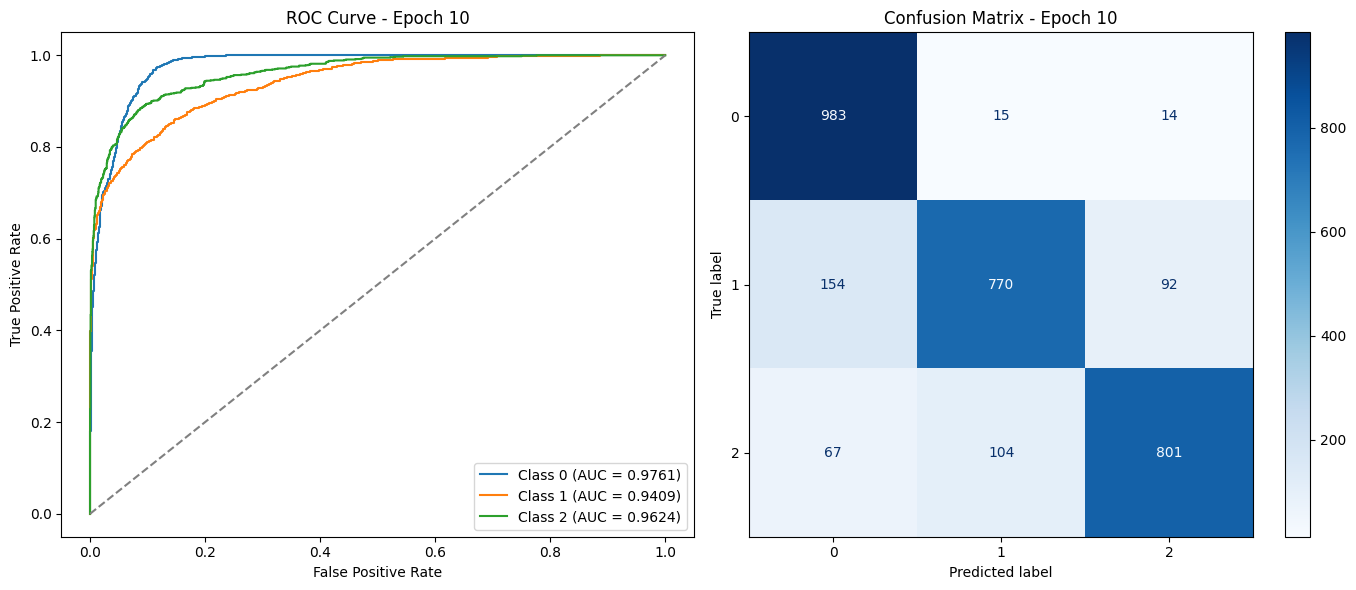

Epoch 11/15


100%|██████████| 422/422 [00:23<00:00, 17.63it/s]


Evaluating on test set...
Test Accuracy: 0.8863


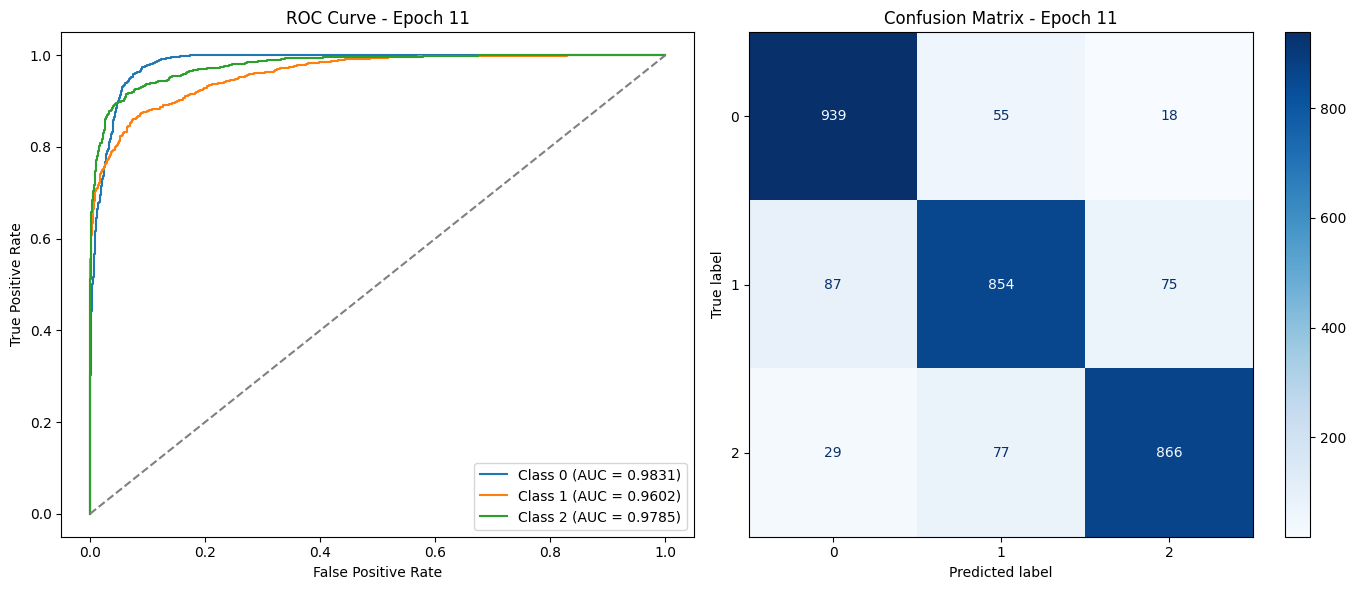

Epoch 12/15


100%|██████████| 422/422 [00:23<00:00, 17.63it/s]


Evaluating on test set...
Test Accuracy: 0.8677


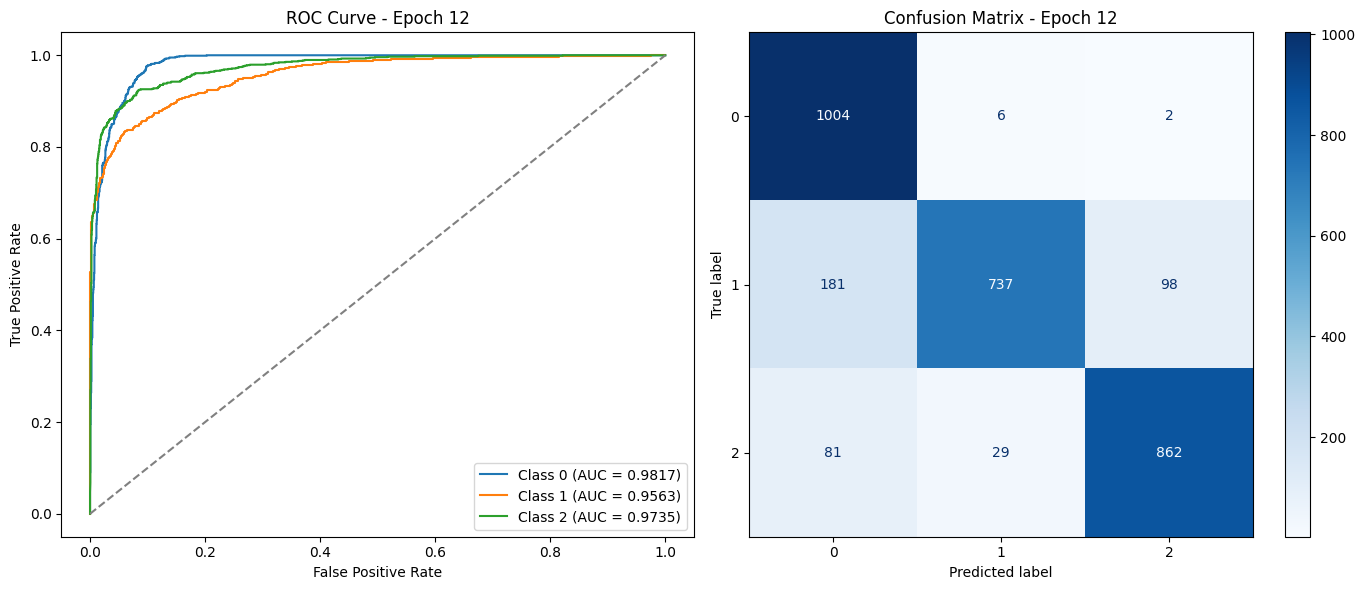

Epoch 13/15


100%|██████████| 422/422 [00:23<00:00, 17.63it/s]


Evaluating on test set...
Test Accuracy: 0.8790


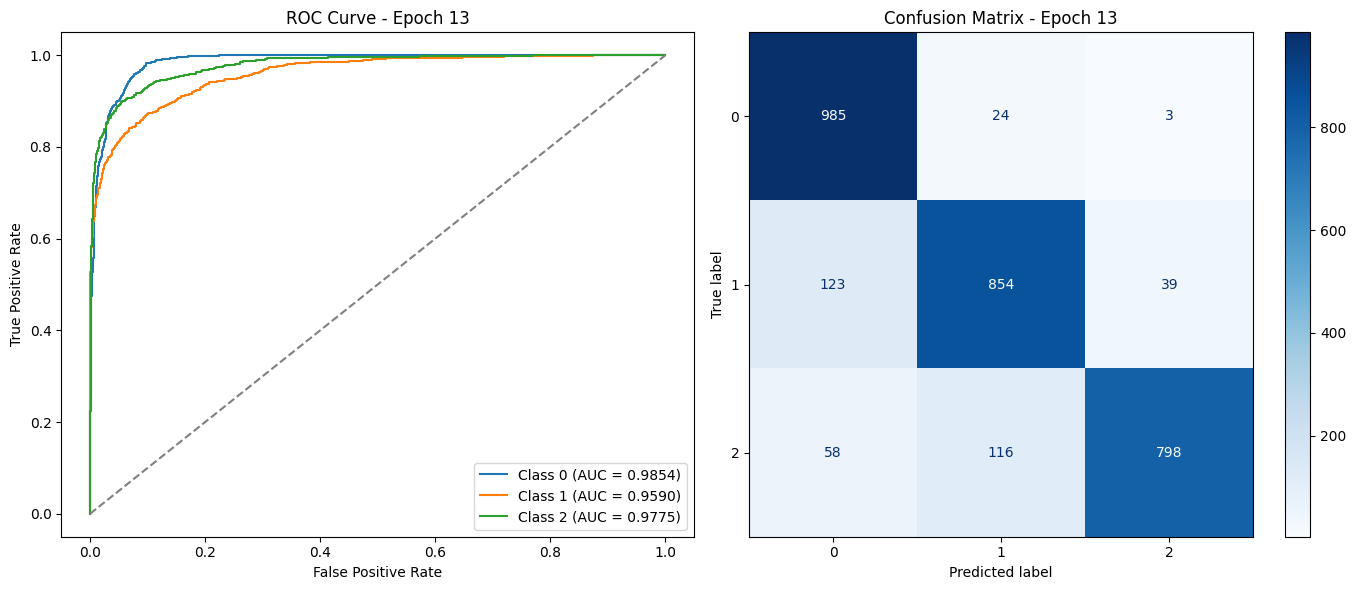

Epoch 14/15


100%|██████████| 422/422 [00:23<00:00, 17.65it/s]


Evaluating on test set...
Test Accuracy: 0.8623


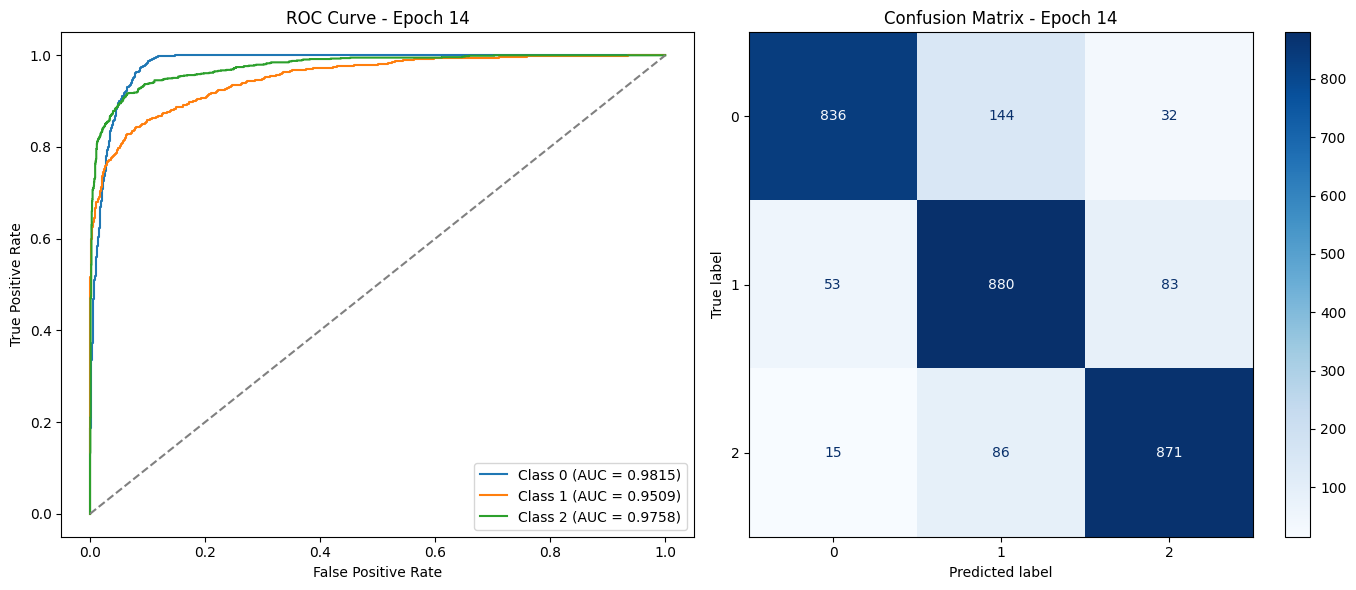

Epoch 15/15


100%|██████████| 422/422 [00:23<00:00, 17.64it/s]


Evaluating on test set...
Test Accuracy: 0.8430


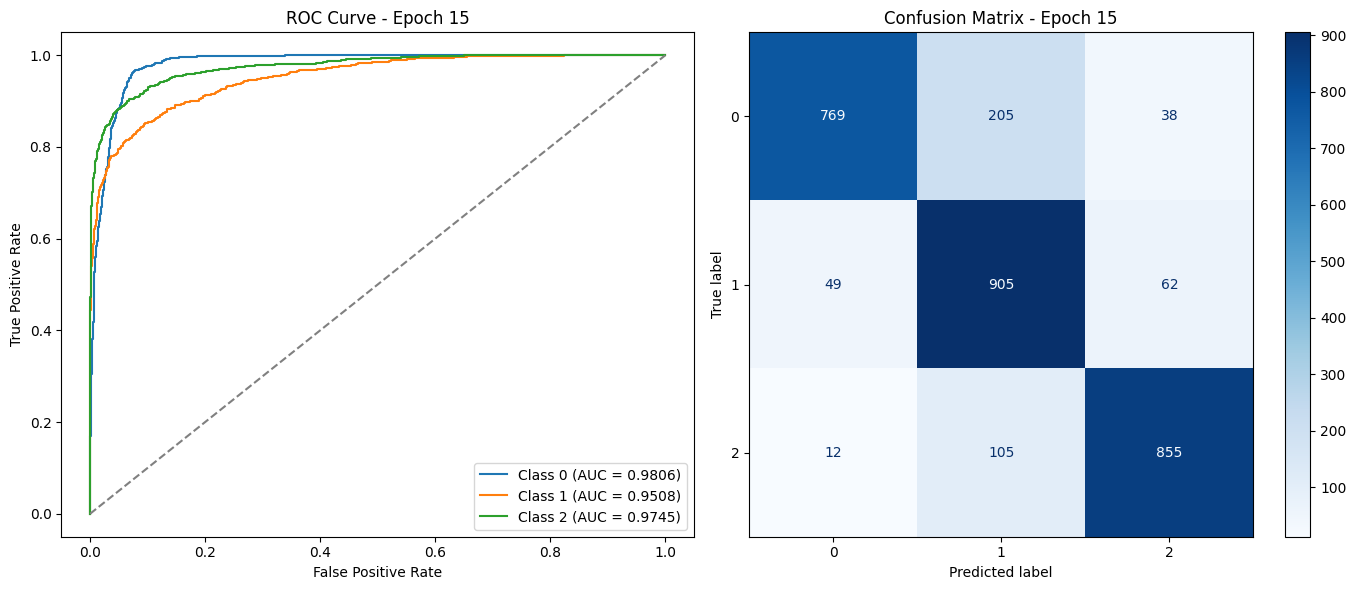

In [23]:
train(train_loader,test_loader,model,criterion,optimizer,15,device)

In [24]:
torch.save(model.state_dict(), "common_task.pth")

# Testing on Test set

ROC-AUC Score: 0.9692


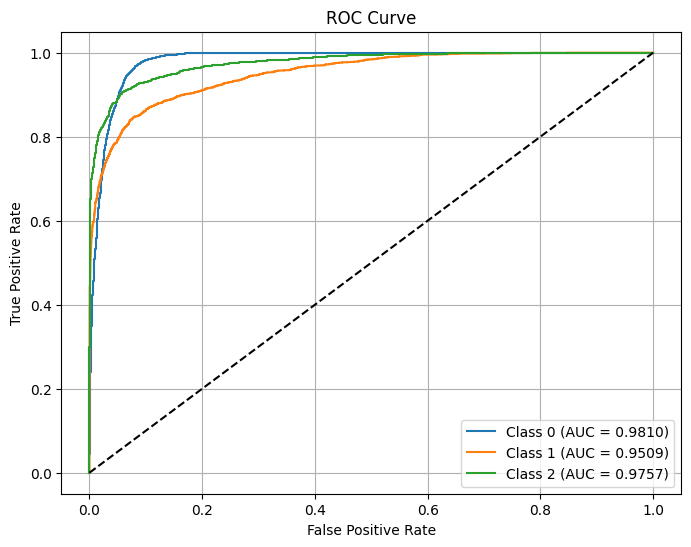

<Figure size 600x600 with 0 Axes>

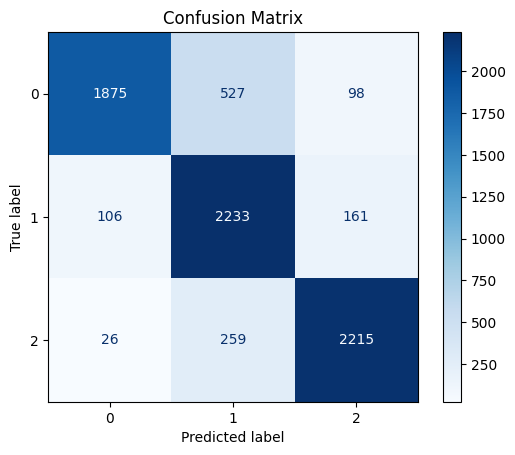

In [25]:
pred(val_loader,model)